In [1]:
import os 
import pandas as pd 
from tqdm import tqdm
from collections import Counter, defaultdict
from itertools import product
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef


In [2]:
path_project = "/media/concha-eloko/Linux/PPT_clean"


raw_df = pd.read_csv(f"{path_project}/raw_metrics.classic_2002.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]

working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]

In [3]:
path_finetuning = "/media/concha-eloko/Linux/PPT_clean/in_vitro/fine_tuning"

bea_df = pd.read_csv(f"{path_finetuning}/bea_fine_tuning.df", sep = "\t", header = 0)
bea_df["Protein"] = bea_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_bea = set([kltype.strip() for kltypes in bea_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

ferriol_df = pd.read_csv(f"{path_finetuning}/ferriol_fine_tuning.df", sep = "\t", header = 0)
ferriol_df["Target"] = ferriol_df["Target"].apply(lambda x : x.replace("K", "KL"))
pool_ferriol = set([kltype.strip() for kltypes in ferriol_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

towndsend_df = pd.read_csv(f"{path_finetuning}/towndsend_fine_tuning.df", sep = "\t", header = 0)
towndsend_df["Protein"] = towndsend_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_towndsend = set([kltype.strip() for kltypes in towndsend_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

dico_matrices = {"ferriol" : {"matrix" : ferriol_df, "pool" : pool_ferriol}, 
                 "bea" : {"matrix": bea_df, "pool" : pool_bea}, 
                 "towndsend" : {"matrix" : towndsend_df, "pool" : pool_towndsend}}

# targets dico : 
dico_hits = {}
for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for _, row in matrix.iterrows() : 
        for phage in matrix["Phages"].unique() : 
            if phage not in phages_to_ignore :
                all_targets = set()
                targets = matrix[matrix["Phages"] == phage]["Target"].values
                for calls in targets : 
                    actual_targets = [x.strip() for x in calls.split(",")]
                    all_targets.update(actual_targets)
                dico_hits[phage] = all_targets




In [4]:
def get_calls_metrics(raw_df , with_fold = False ,top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_good_calls = []
    TropiSeq_good_calls = []
    
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            combinations = set(product([phage], list(targets_set)))
            total_calls = total_calls + list(combinations)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                # TropiGAT calls : 
                call_tropigat = set()
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropigat.update(top_n_predictions)
                good_calls_tropigat = call_tropigat.intersection(targets_set)
                if len(good_calls_tropigat) > 0 :
                    for kltype in good_calls_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_good_calls.append(a)
                # TropiSeq calls : 
                call_tropiseq = set()
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropiseq.update(top_n_predictions)
                good_calls_tropiseq = call_tropiseq.intersection(targets_set)
                if len(good_calls_tropiseq) > 0 :
                    for kltype in good_calls_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_good_calls.append(a)
    all_calls = set(TropiGAT_good_calls).union(set(TropiSeq_good_calls))

    return total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls

In [5]:
# Compute :
total_calls, all_calls , TropiGAT_good_calls , _ = get_calls_metrics(working_df, top_n = 40, to_ignore = phages_to_ignore)
total_calls, all_calls , _ , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = 40, to_ignore = phages_to_ignore)

# TropiSeq : 
Tropiseq_unique = set(TropiSeq_good_calls) - set(TropiGAT_good_calls)
# TropiGAT :
Tropigat_unique = set(TropiGAT_good_calls) - set(TropiSeq_good_calls)
# Combo :
common_ground = set(TropiGAT_good_calls) & set(TropiSeq_good_calls)

In [7]:
# Get the y axis :
big_pool = []

for author in dico_matrices :
    big_pool = big_pool + list(dico_matrices[author]["pool"])
    
big_pool = list(set(big_pool))
big_pool.sort(key = lambda x : int(x.split("KL")[1]))

# Get the x axis :
phages_vectors = {}

for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for phage in matrix["Phages"].unique() :
        vector = []
        if phage not in phages_to_ignore :
            if str(dico_hits[phage]).count("pass") == 0 :
                for _,kltype in enumerate(big_pool) :
                    if kltype in dico_matrices[author]["pool"] :
                        if kltype in dico_hits[phage] :
                            pair = (phage, kltype)
                            if pair in Tropigat_unique :
                                vector.append(0.5)
                            elif pair in Tropiseq_unique :
                                vector.append(0.75)
                            elif pair in common_ground :
                                vector.append(1)
                            else :
                                vector.append(0.25)
                        else :
                            vector.append(0.1)
                    else :
                        vector.append(0)
                phages_vectors[phage] = vector


In [8]:
df = pd.DataFrame(phages_vectors)
transposed_df = df.T
transposed_df.columns = big_pool



> Plot the matrix

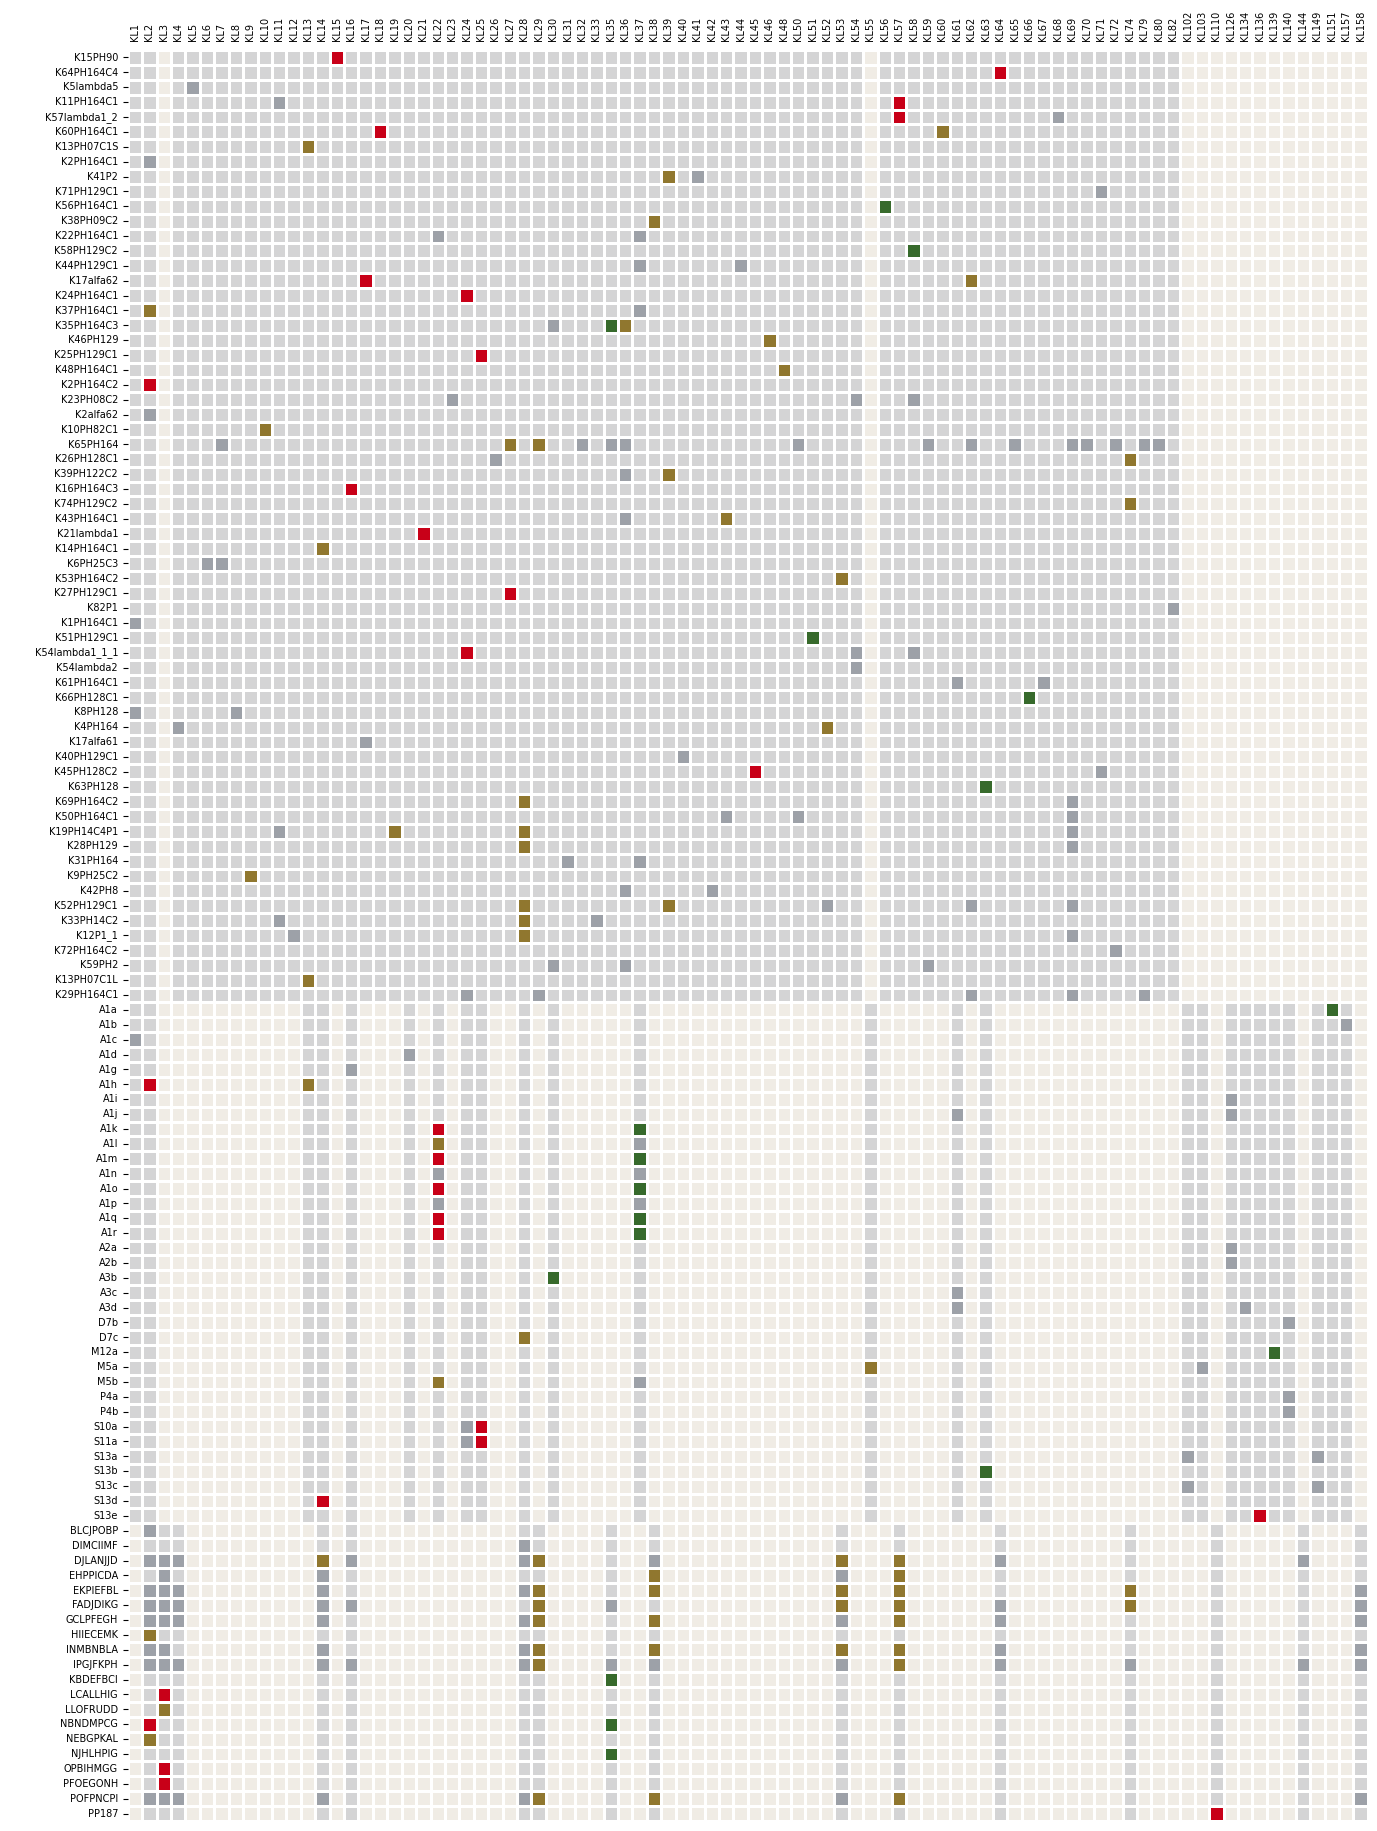

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", #7D7C7C
    0.5 : "#C9980B",
    0.75 : "#0A5C36",  #3A5A40
    1: '#C80018',    
}

custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f,ax = plt.subplots(figsize=(16, 23))

sns.set(style="white", palette="binary")
sns_plot= sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar =False, 
                      linewidths=1.9, 
                      ax = ax, 
                      yticklabels=True,
                      xticklabels= True,
                      cmap = custom_cmap) #rocket_r , mako_r

ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize = 7 ,rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize = 7) #fontweight='bold'
#f.savefig(path_out+"/matrix_lytic_phages.top40.svg", dpi=600)
f.savefig(path_out+"/matrix_lytic_phages.top40.2304.png", transparent = True, dpi=600)

plt.show()

***
## Plot depolymerase folds :

In [9]:
path_project = "/media/concha-eloko/Linux/PPT_clean"


raw_df = pd.read_csv(f"{path_project}/raw_metrics.classic_2002.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]

working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]

In [10]:
dico_folds = {}

for phage in working_df.Phage.unique() :
    folds_arr = working_df[working_df["Phage"] == phage]["Folds"].values
    dico_count = dict(Counter(folds_arr))
    dico_folds[phage] = dico_count

In [11]:
dico_folds

{'A1a': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1b': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1c': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1d': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1g': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1h': {'right-handed beta-helix': 2, '6-bladed beta-propeller': 1},
 'A1i': {'right-handed beta-helix': 2, '6-bladed beta-propeller': 1},
 'A1j': {'right-handed beta-helix': 2, '6-bladed beta-propeller': 1},
 'A1k': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1l': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1m': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 1},
 'A1n': {'6-bladed beta-propeller': 1},
 'A1o': {'right-handed beta-helix': 1, '6-bladed beta-propeller': 1},
 'A1p': {'6-bladed beta-propeller': 1},
 'A1q': {'6-bladed beta-propeller': 1, 'right-handed beta-helix': 2},
 'A1r': {'

In [11]:
nested_dico_folds = {}

for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    phages = matrix.Phages.unique()
    subset_dictionary = {key: dico_folds[key] for key in phages if key in dico_folds}
    nested_dico_folds[author] = subset_dictionary
    

***
### Plot the matrix :

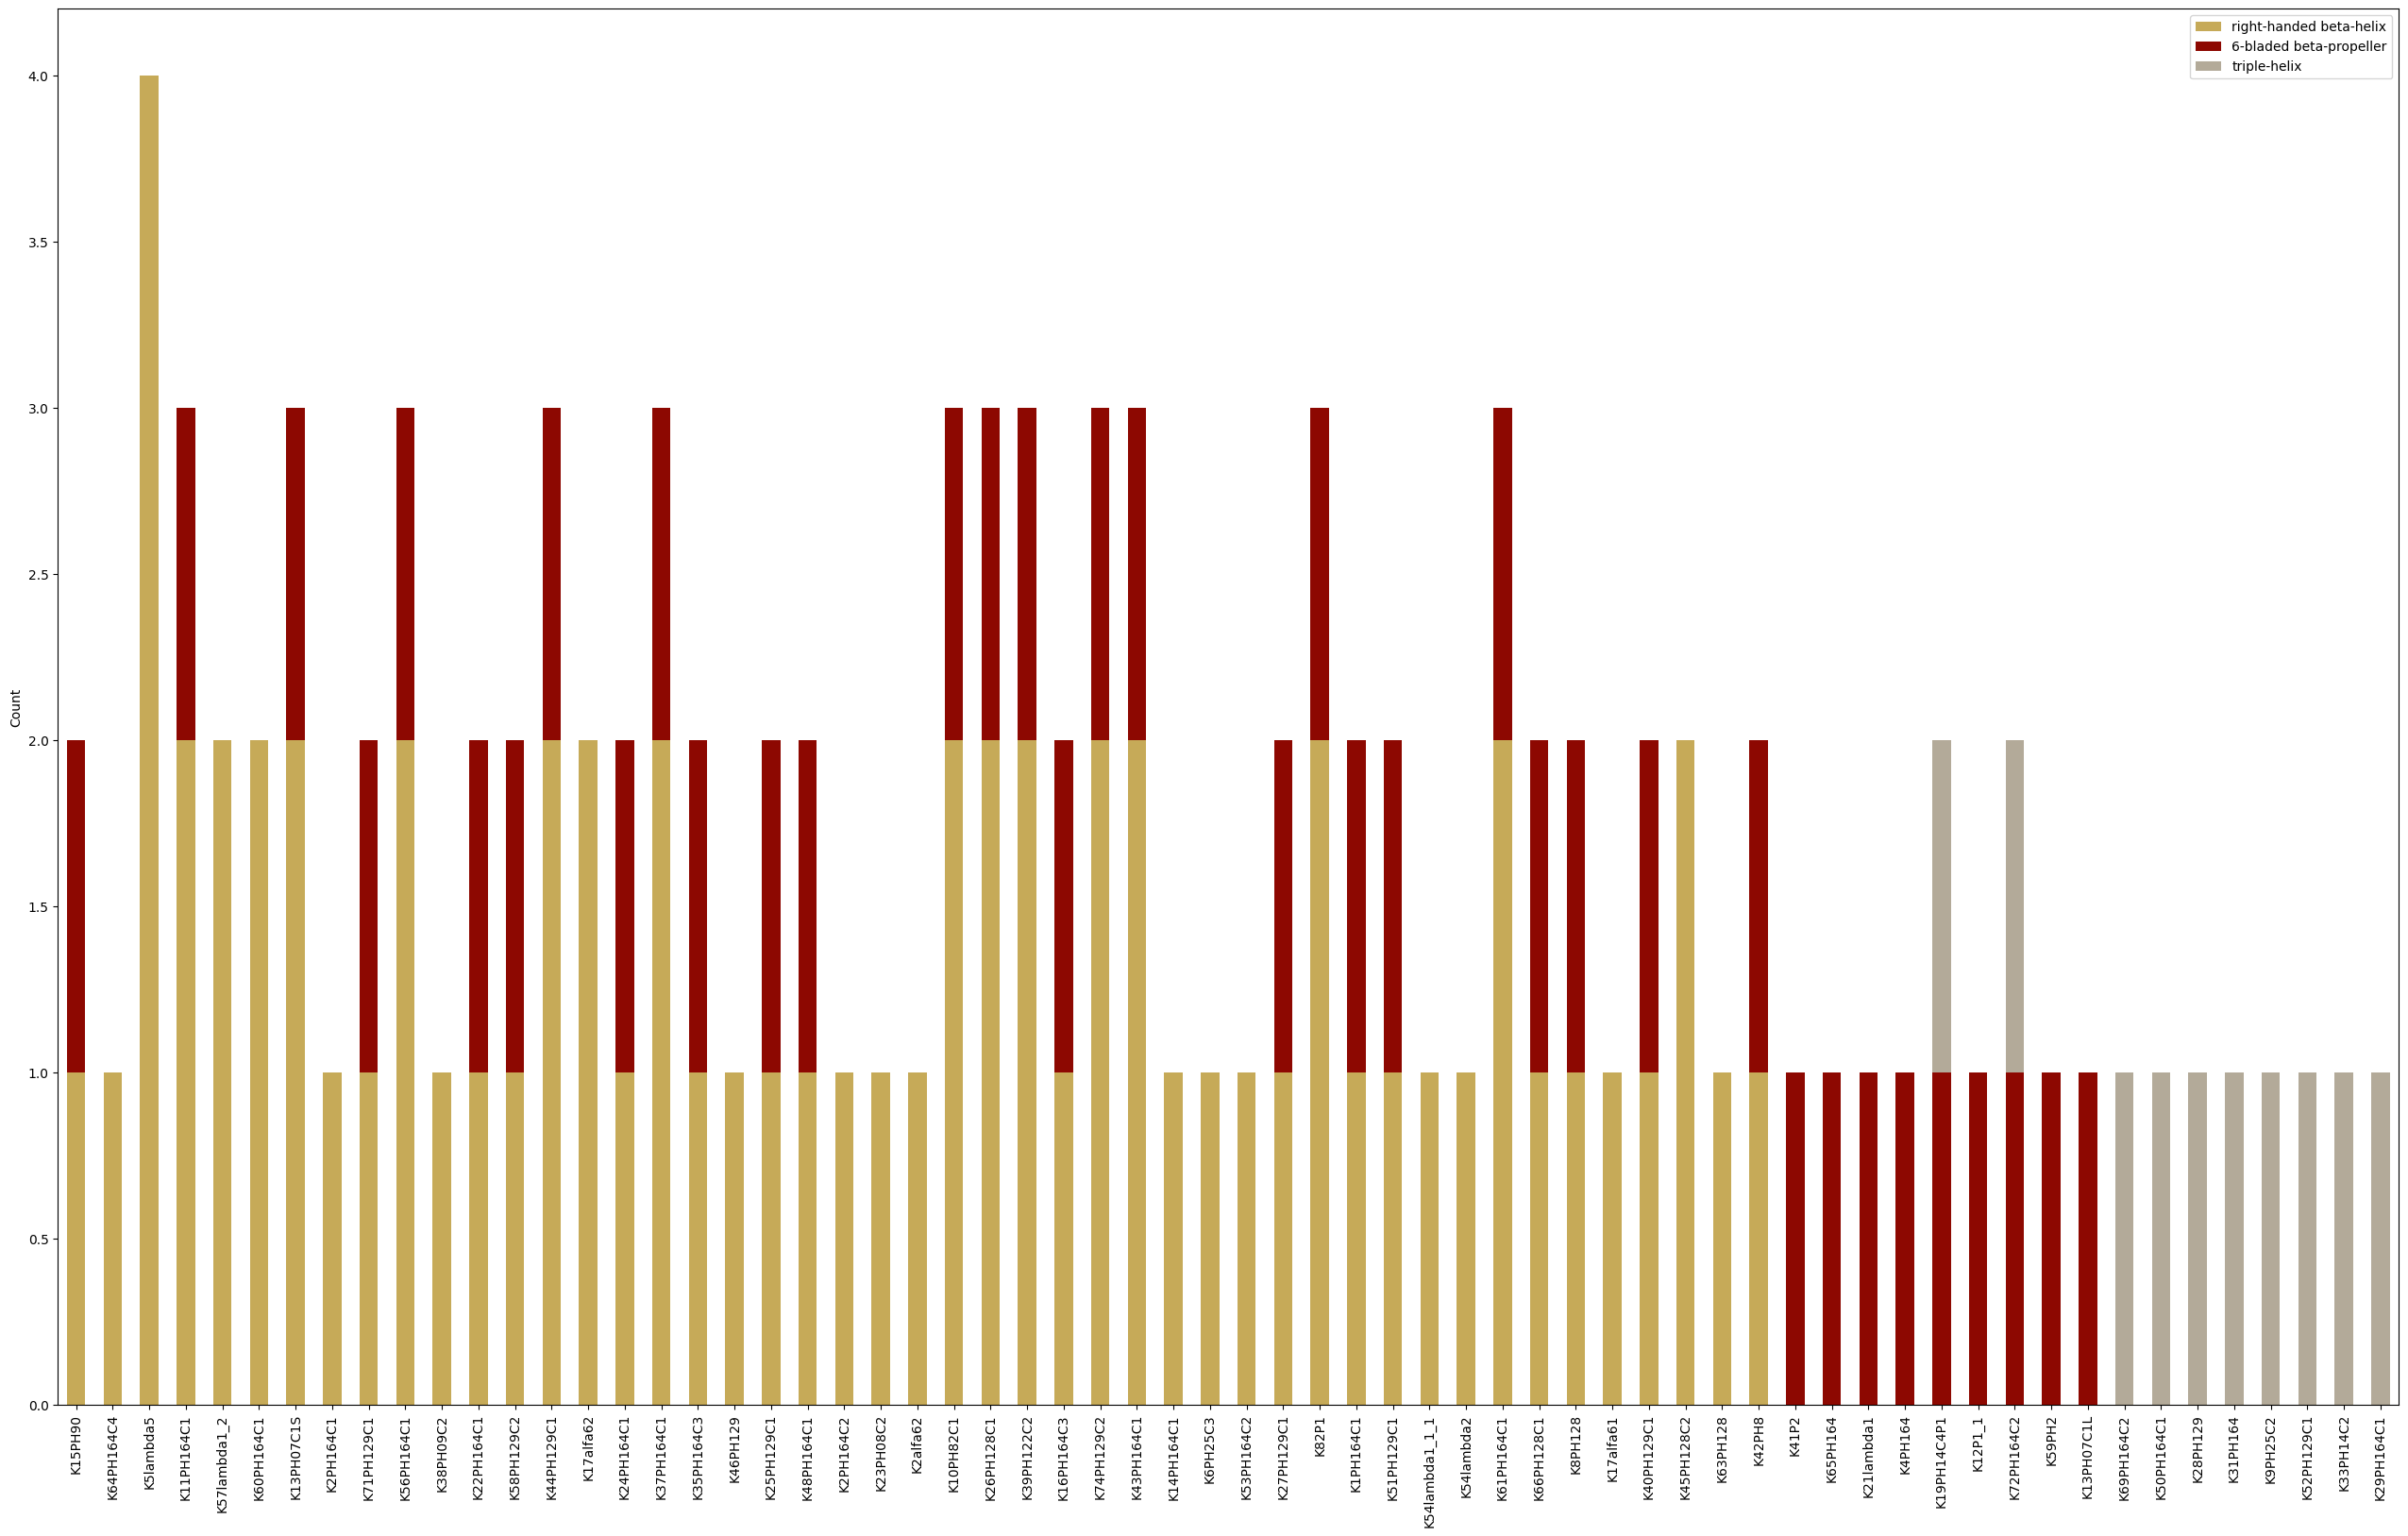

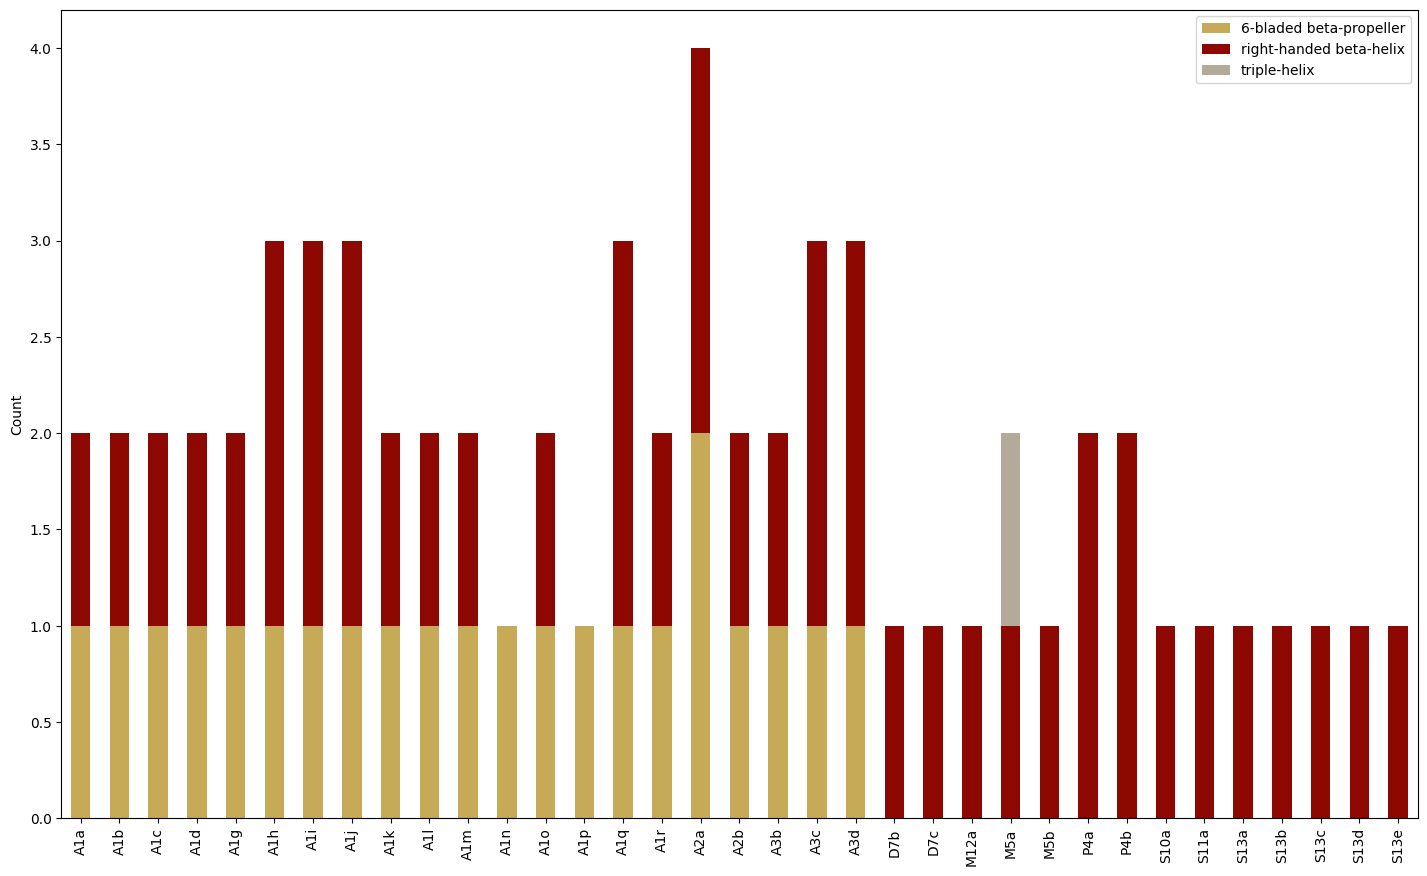

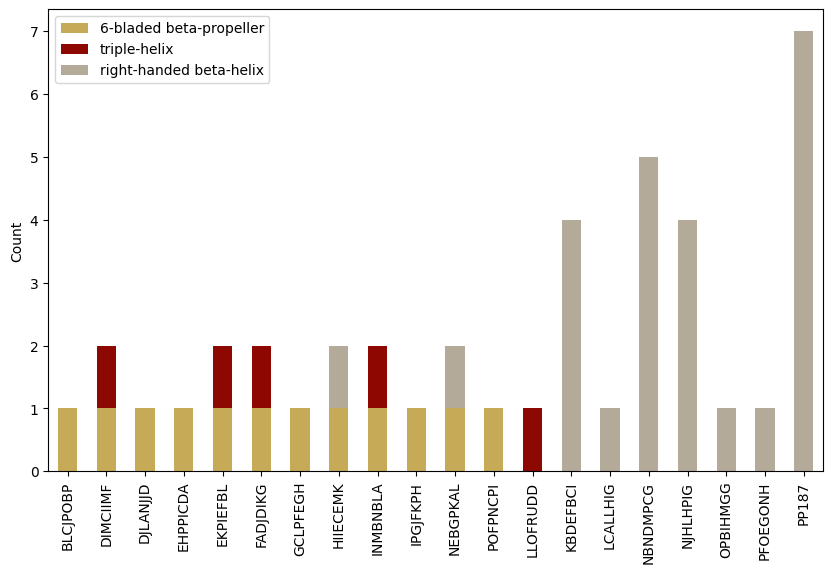

In [14]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

def plot_from_dic(data_dict, author):
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    color_dict = {'right-handed beta-helix': '#c6aa58ff', 
                  '6-bladed beta-propeller': '#8d0801ff', 
                  'triple-helix': '#b3aa99ff'}
    #colors = ['#c6aa58ff', '#8d0801ff', '#b3aa99ff']  # Colors for the bars
    num_elements = len(df.index)  # Number of elements in the x-axis
    figsize = (num_elements*0.5, num_elements*0.3)  # Adjust the width of the figure based on the number of elements
    df.plot(kind='bar', stacked=True, color = color_dict.values(), figsize=figsize)  # Plot
    plt.ticklabel_format(style='plain', useOffset=False, axis='y')  # No offset
    plt.gca().set_ylabel("Count")  # Set Y-axis label
    plt.savefig(f'{path_out}/{author}_stacked_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

for author in nested_dico_folds:
    dico = nested_dico_folds[author]
    plot_from_dic(dico, author)

***
## Plot both :

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", #7D7C7C
    0.5 : "#C9980B",
    0.75 : "#0A5C36",  #3A5A40
    1: '#C80018',    
}

custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f,ax = plt.subplots(figsize=(16, 23))

sns.set(style="white", palette="binary")
sns_plot= sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar =False, 
                      linewidths=1.9, 
                      ax = ax, 
                      yticklabels=True,
                      xticklabels= True,
                      cmap = custom_cmap) #rocket_r , mako_r

ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize = 7 ,rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize = 7) #fontweight='bold'
#f.savefig(path_out+"/matrix_lytic_phages.top40.svg", dpi=600)
f.savefig(path_out+"/matrix_lytic_phages.top40.png", transparent = True, dpi=600)

plt.show()

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

def plot_from_dic(data_dict):
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    color_dict = {'right-handed beta-helix': '#c6aa58ff', 
                  '6-bladed beta-propeller': '#8d0801ff', 
                  'triple-helix': '#b3aa99ff'}
    #colors = ['#c6aa58ff', '#8d0801ff', '#b3aa99ff']  # Colors for the bars
    num_elements = len(df.index)  # Number of elements in the x-axis
    figsize = (num_elements*0.5, num_elements*0.3)  # Adjust the width of the figure based on the number of elements
    df.plot(kind='bar', stacked=True, color = color_dict.values(), figsize=figsize)  # Plot
    plt.ticklabel_format(style='plain', useOffset=False, axis='y')  # No offset
    plt.gca().set_ylabel("Count")  # Set Y-axis label
    plt.savefig(f'{path_out}/all_stacked_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_from_dic(all_folds)

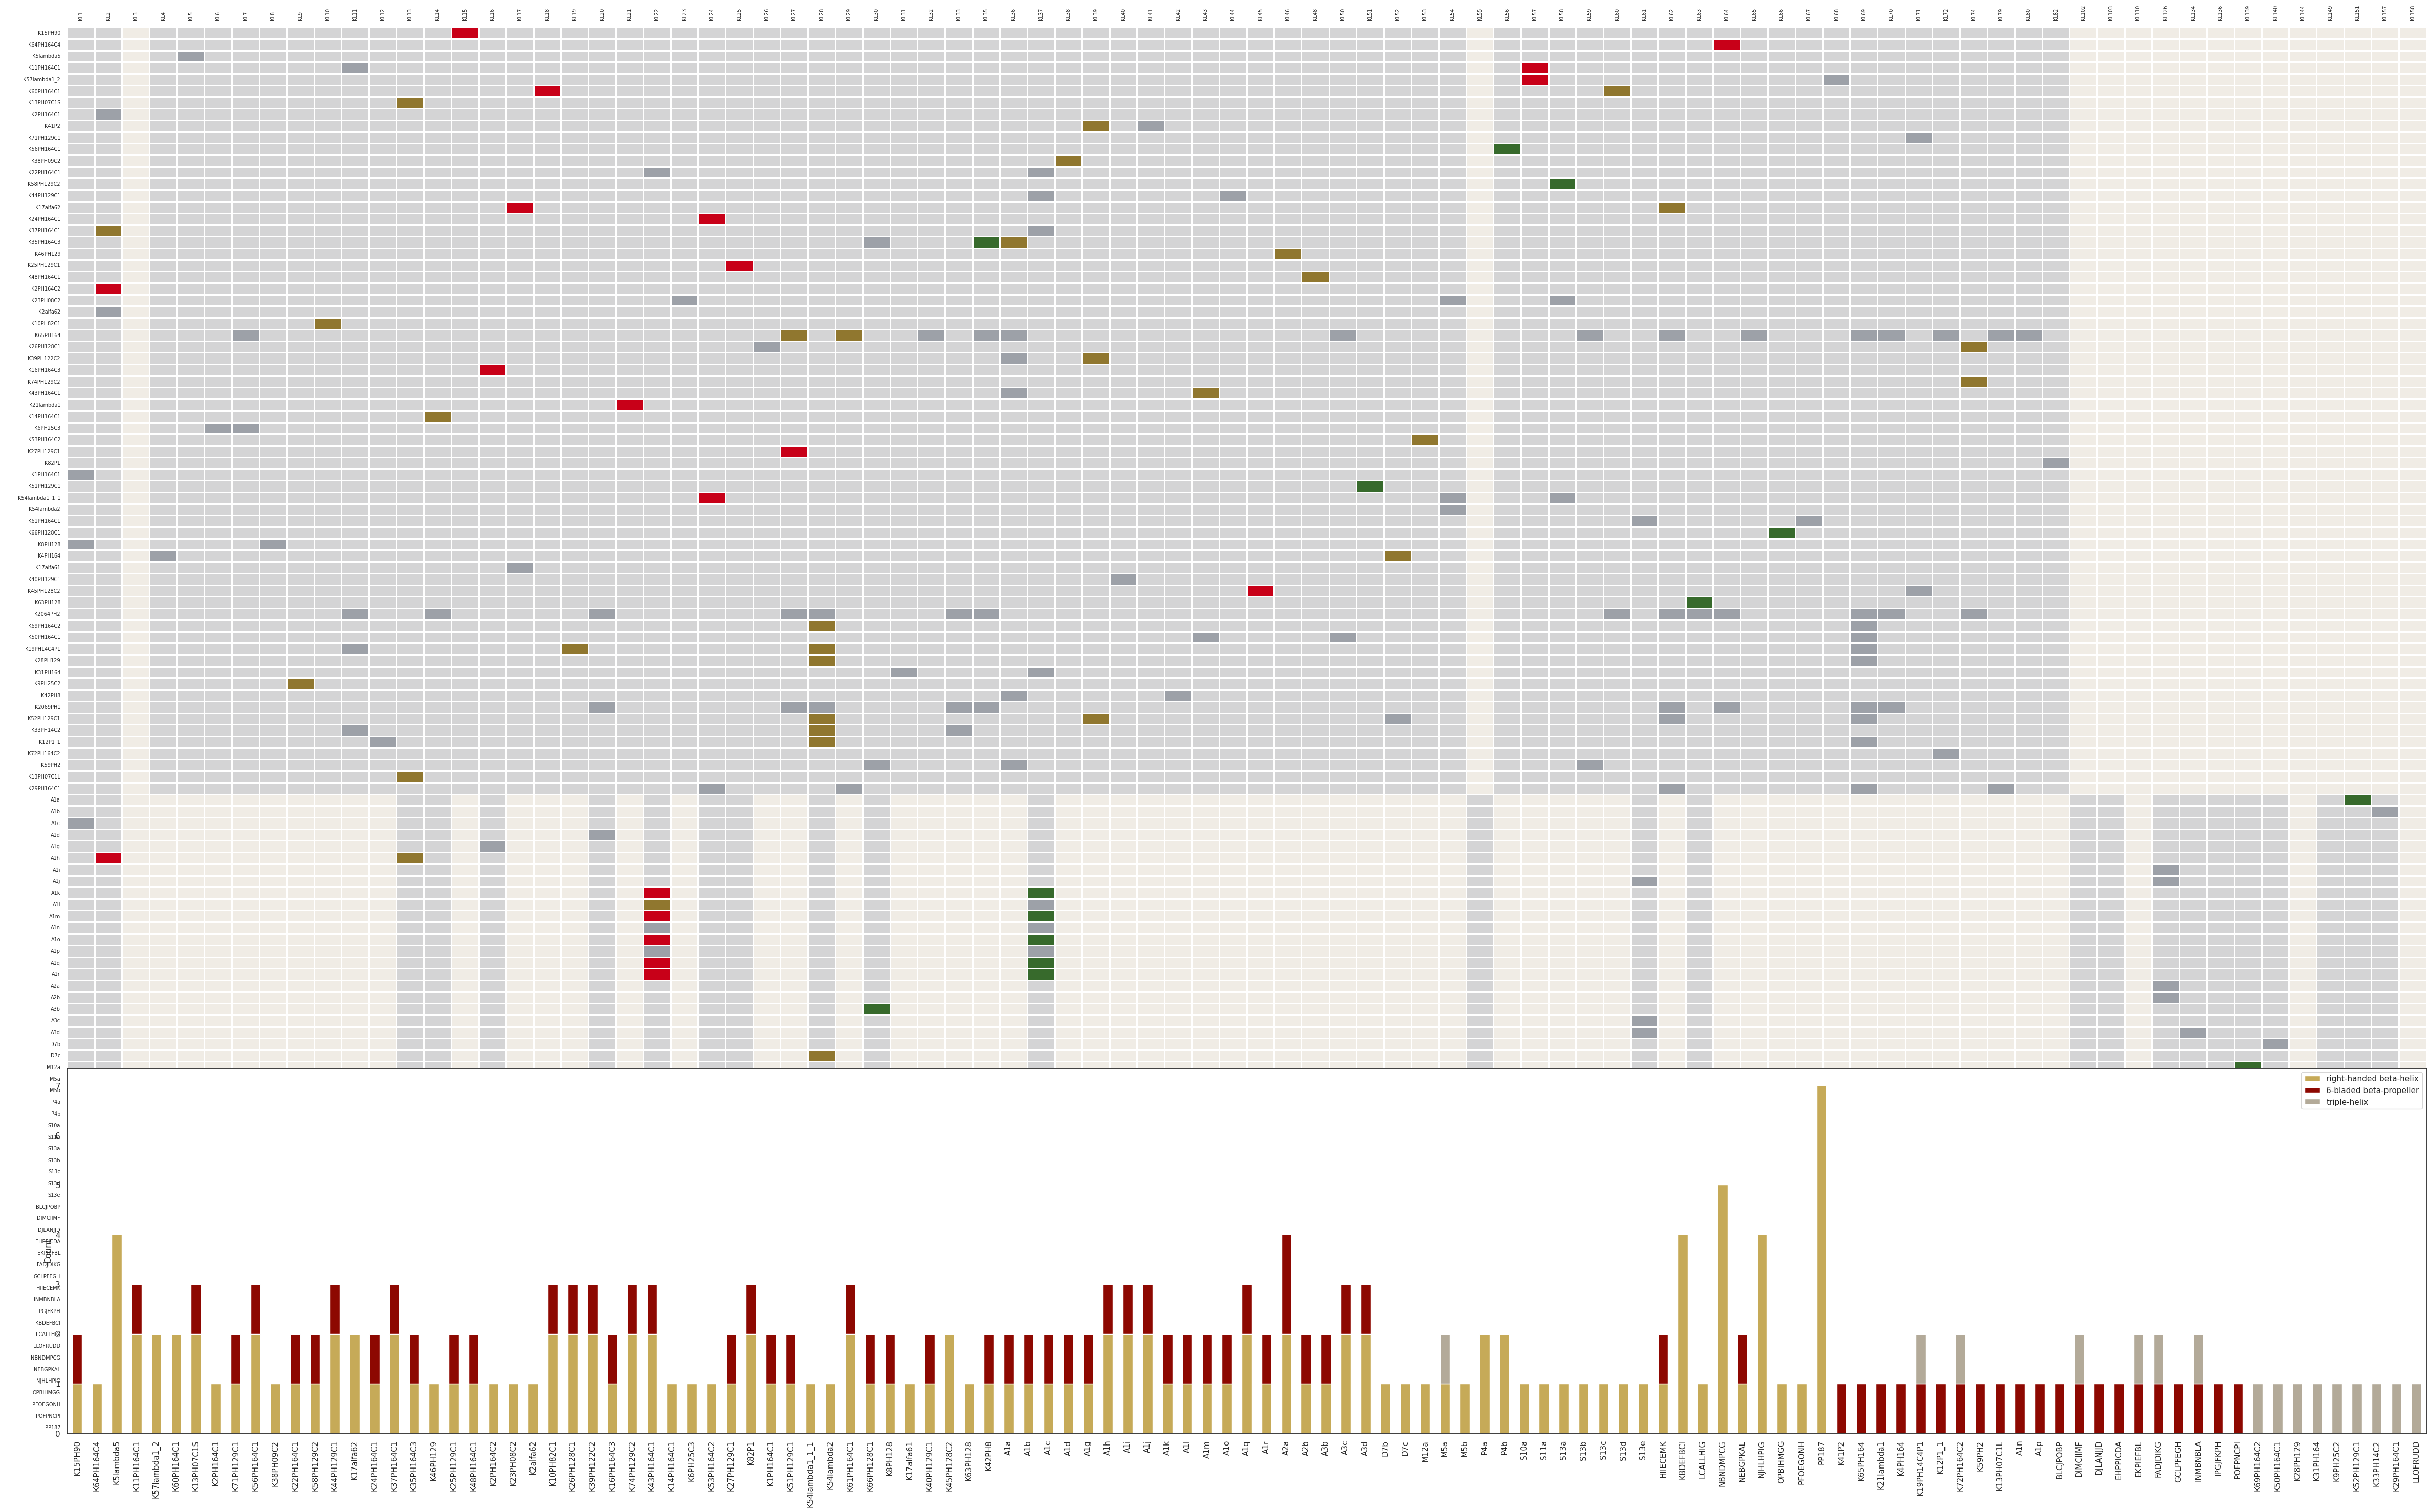

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

# Create the matrix plot (heatmap)
custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", 
    0.5 : "#C9980B",
    0.75 : "#0A5C36", 
    1: '#C80018',    
}
custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f, ax = plt.subplots(figsize=(16, 23))
sns.set(style="white", palette="binary")
sns_plot = sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar=False, 
                      linewidths=1.9, 
                      ax=ax, 
                      yticklabels=True,
                      xticklabels=True,
                      cmap=custom_cmap)
ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize=7, rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize=7)
f.savefig(path_out+"/matrix_lytic_phages.top40.png", transparent=True, dpi=600)

# Create the barplot
def plot_from_dic(data_dict):
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    color_dict = {'right-handed beta-helix': '#c6aa58ff', 
                  '6-bladed beta-propeller': '#8d0801ff', 
                  'triple-helix': '#b3aa99ff'}
    num_elements = len(df.index)
    figsize = (num_elements*0.5, num_elements*0.3)
    ax2 = plt.subplot(gs[1])  # Add the barplot to the second subplot
    df.plot(kind='bar', stacked=True, color=color_dict.values(), figsize=figsize, ax=ax2)
    plt.ticklabel_format(style='plain', useOffset=False, axis='y')
    plt.gca().set_ylabel("Count")
    plt.savefig(f'{path_out}/all_stacked_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create a grid layout
gs = GridSpec(2, 1, height_ratios=[5, 2])

# Plot the barplot within the grid
plot_from_dic(all_folds)

plt.show()

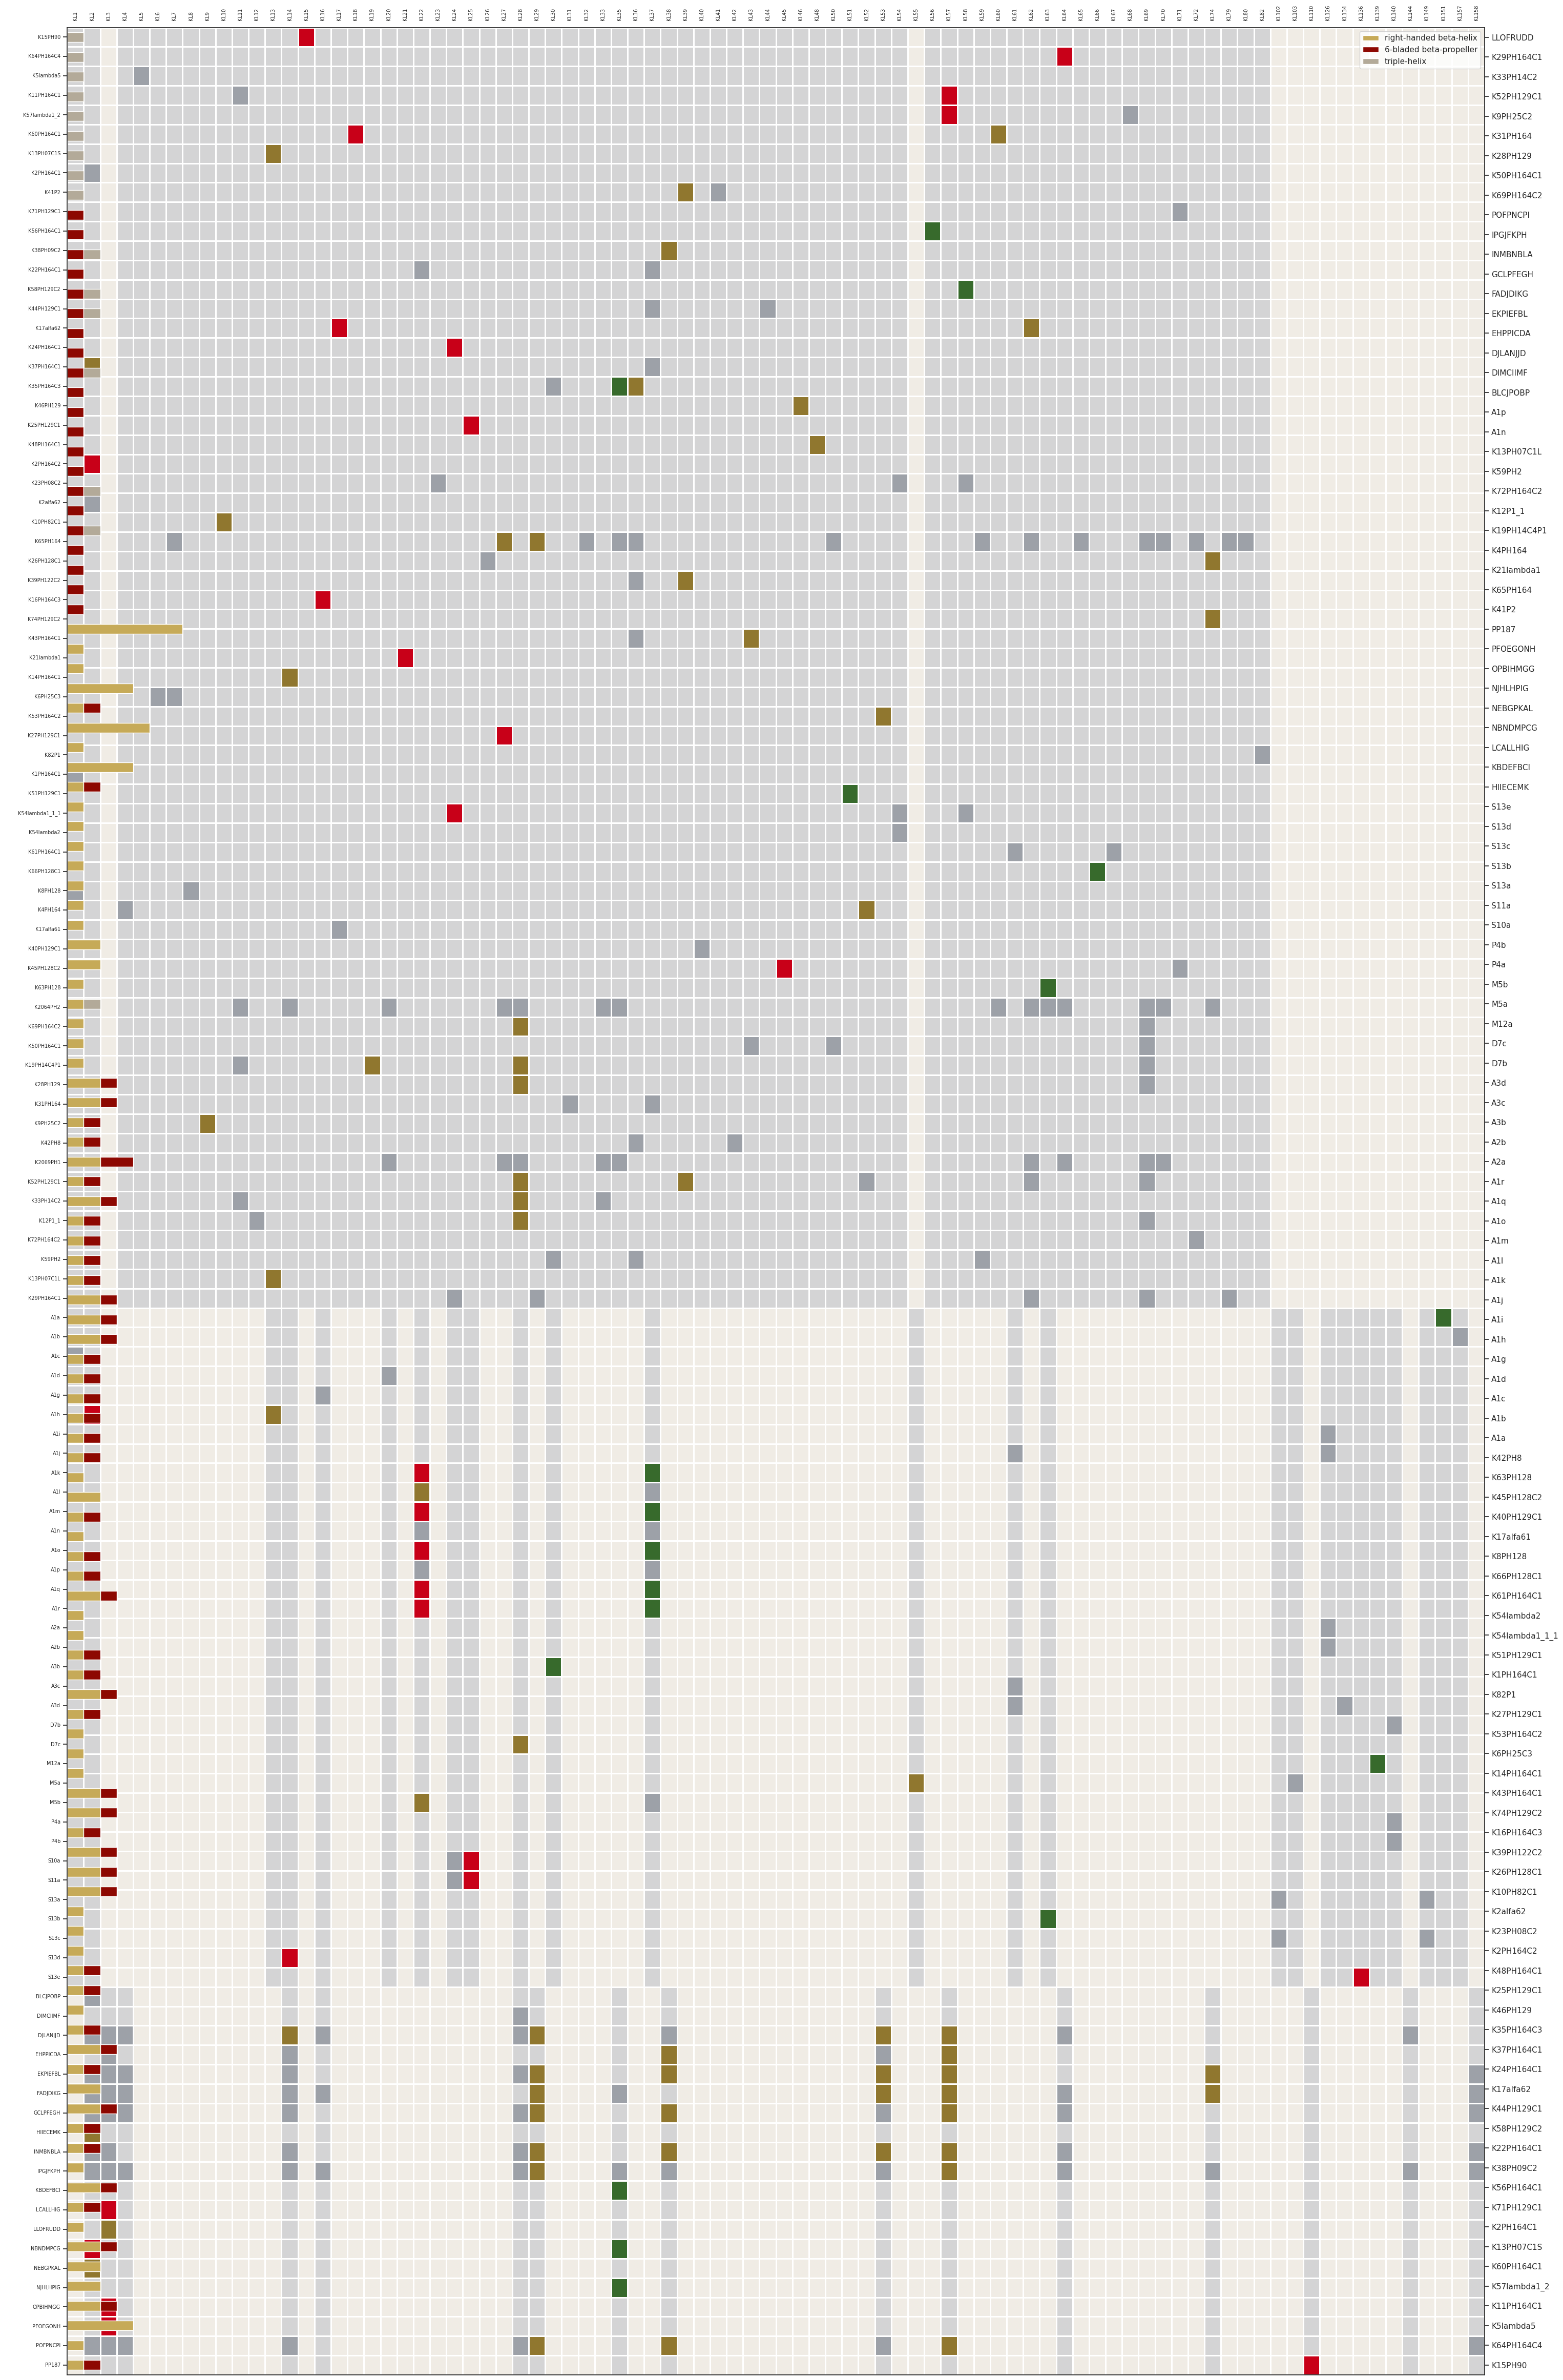

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

# Create the matrix plot (heatmap)
custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", 
    0.5 : "#C9980B",
    0.75 : "#0A5C36", 
    1: '#C80018',    
}
custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f, ax = plt.subplots(figsize=(16, 23))
sns.set(style="white", palette="binary")
sns_plot = sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar=False, 
                      linewidths=1.9, 
                      ax=ax, 
                      yticklabels=True,
                      xticklabels=True,
                      cmap=custom_cmap)
ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize=7, rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize=7)
f.savefig(path_out+"/matrix_lytic_phages.top40.png", transparent=True, dpi=600)

# Create the barplot
def plot_from_dic(data_dict):
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    color_dict = {'right-handed beta-helix': '#c6aa58ff', 
                  '6-bladed beta-propeller': '#8d0801ff', 
                  'triple-helix': '#b3aa99ff'}
    num_elements = len(df.index)
    figsize = (num_elements*0.3, num_elements*0.5)  # Adjust the size for proper visualization
    ax2 = plt.twinx()  # Create a twin Axes sharing the yaxis
    df.plot(kind='barh', stacked=True, color=color_dict.values(), figsize=figsize, ax=ax2)
    #plt.ticklabel_format(style='plain', useOffset=False, axis='x')
    plt.gca().set_xlabel("Count")
    plt.savefig(f'{path_out}/all_stacked_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the barplot
plot_from_dic(all_folds)

plt.show()

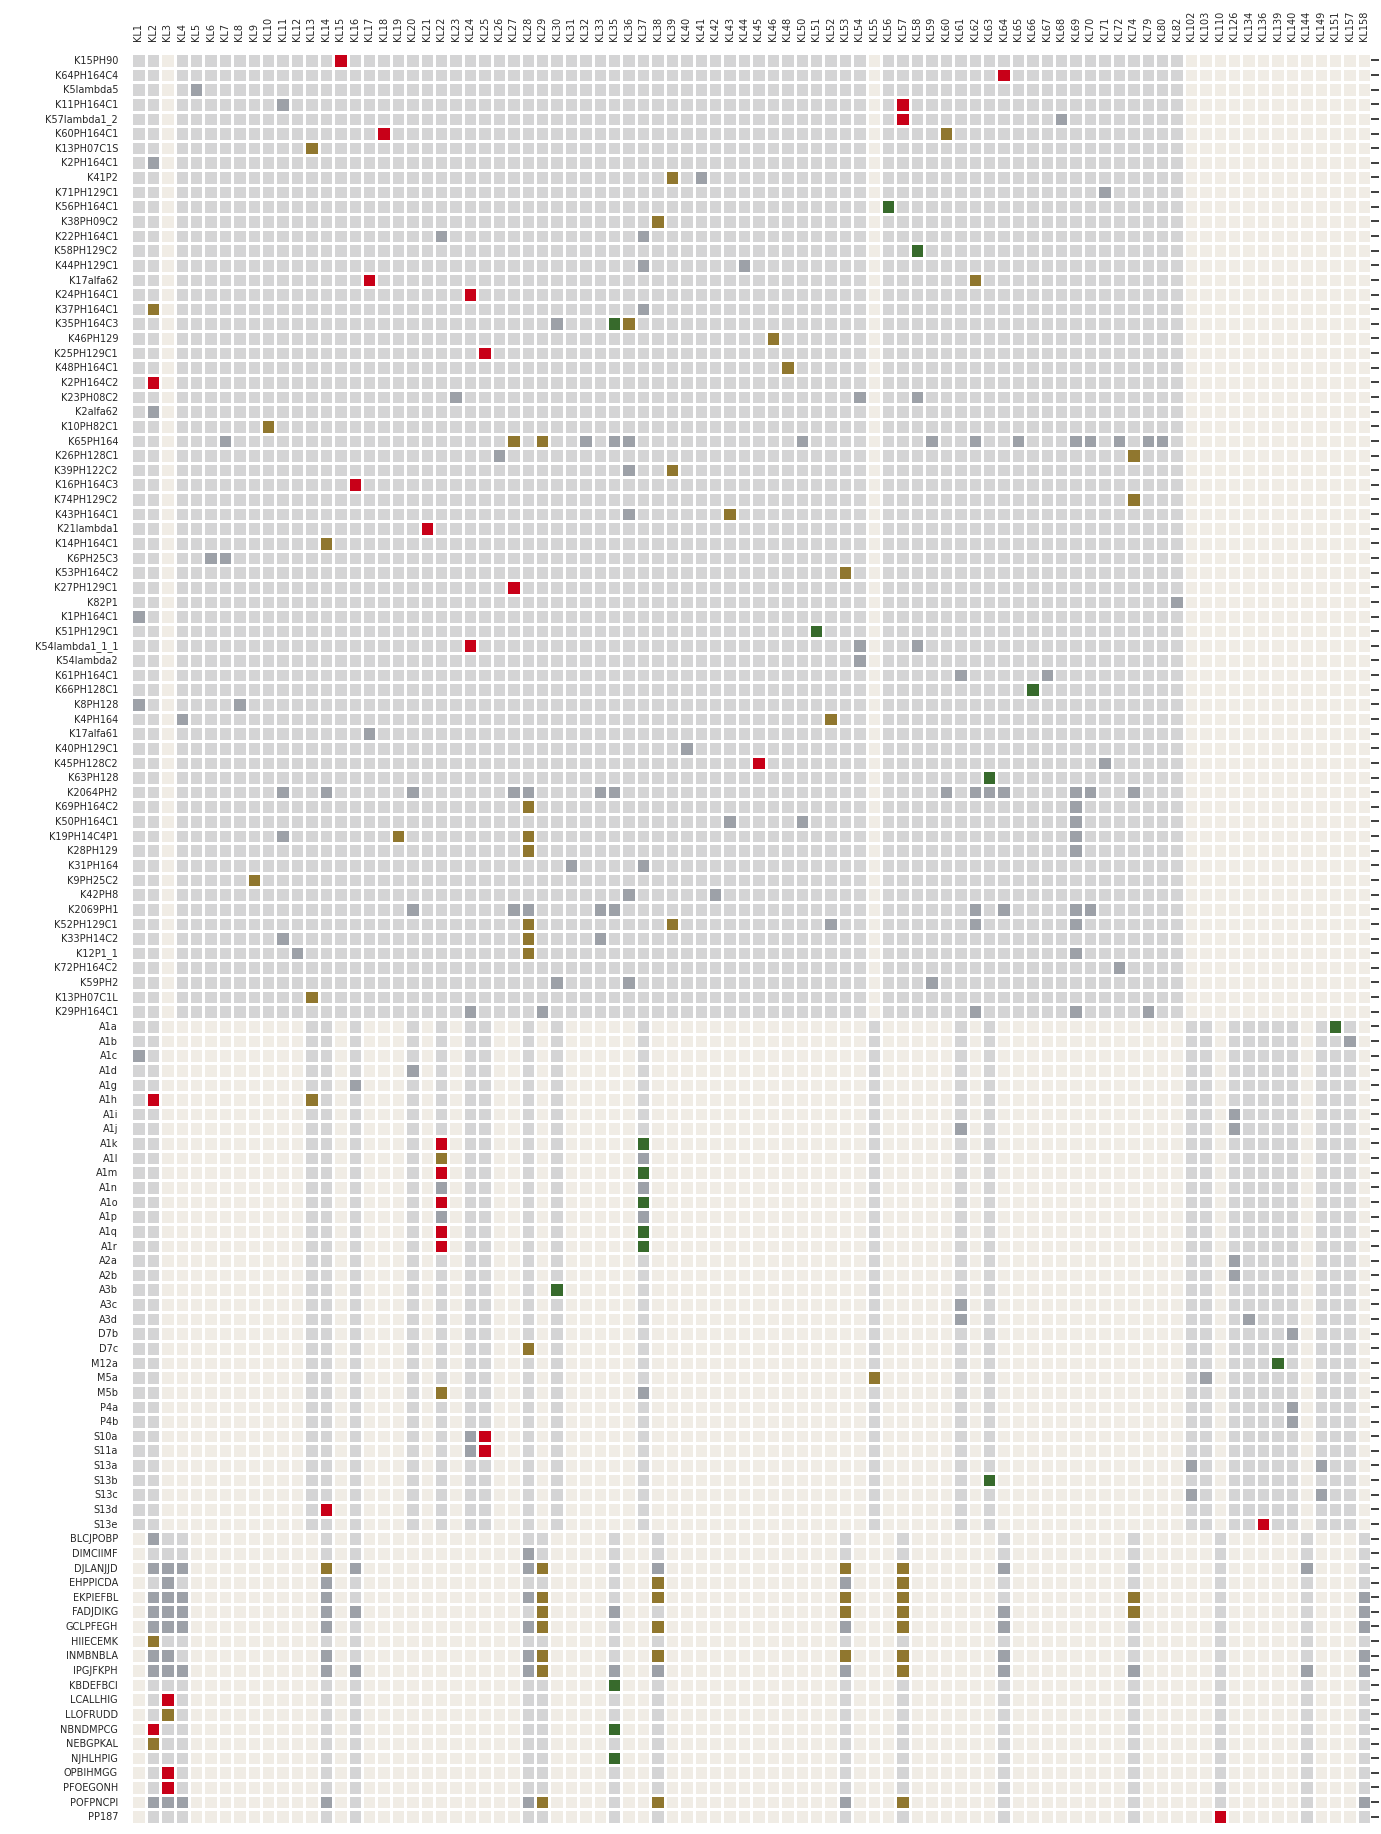

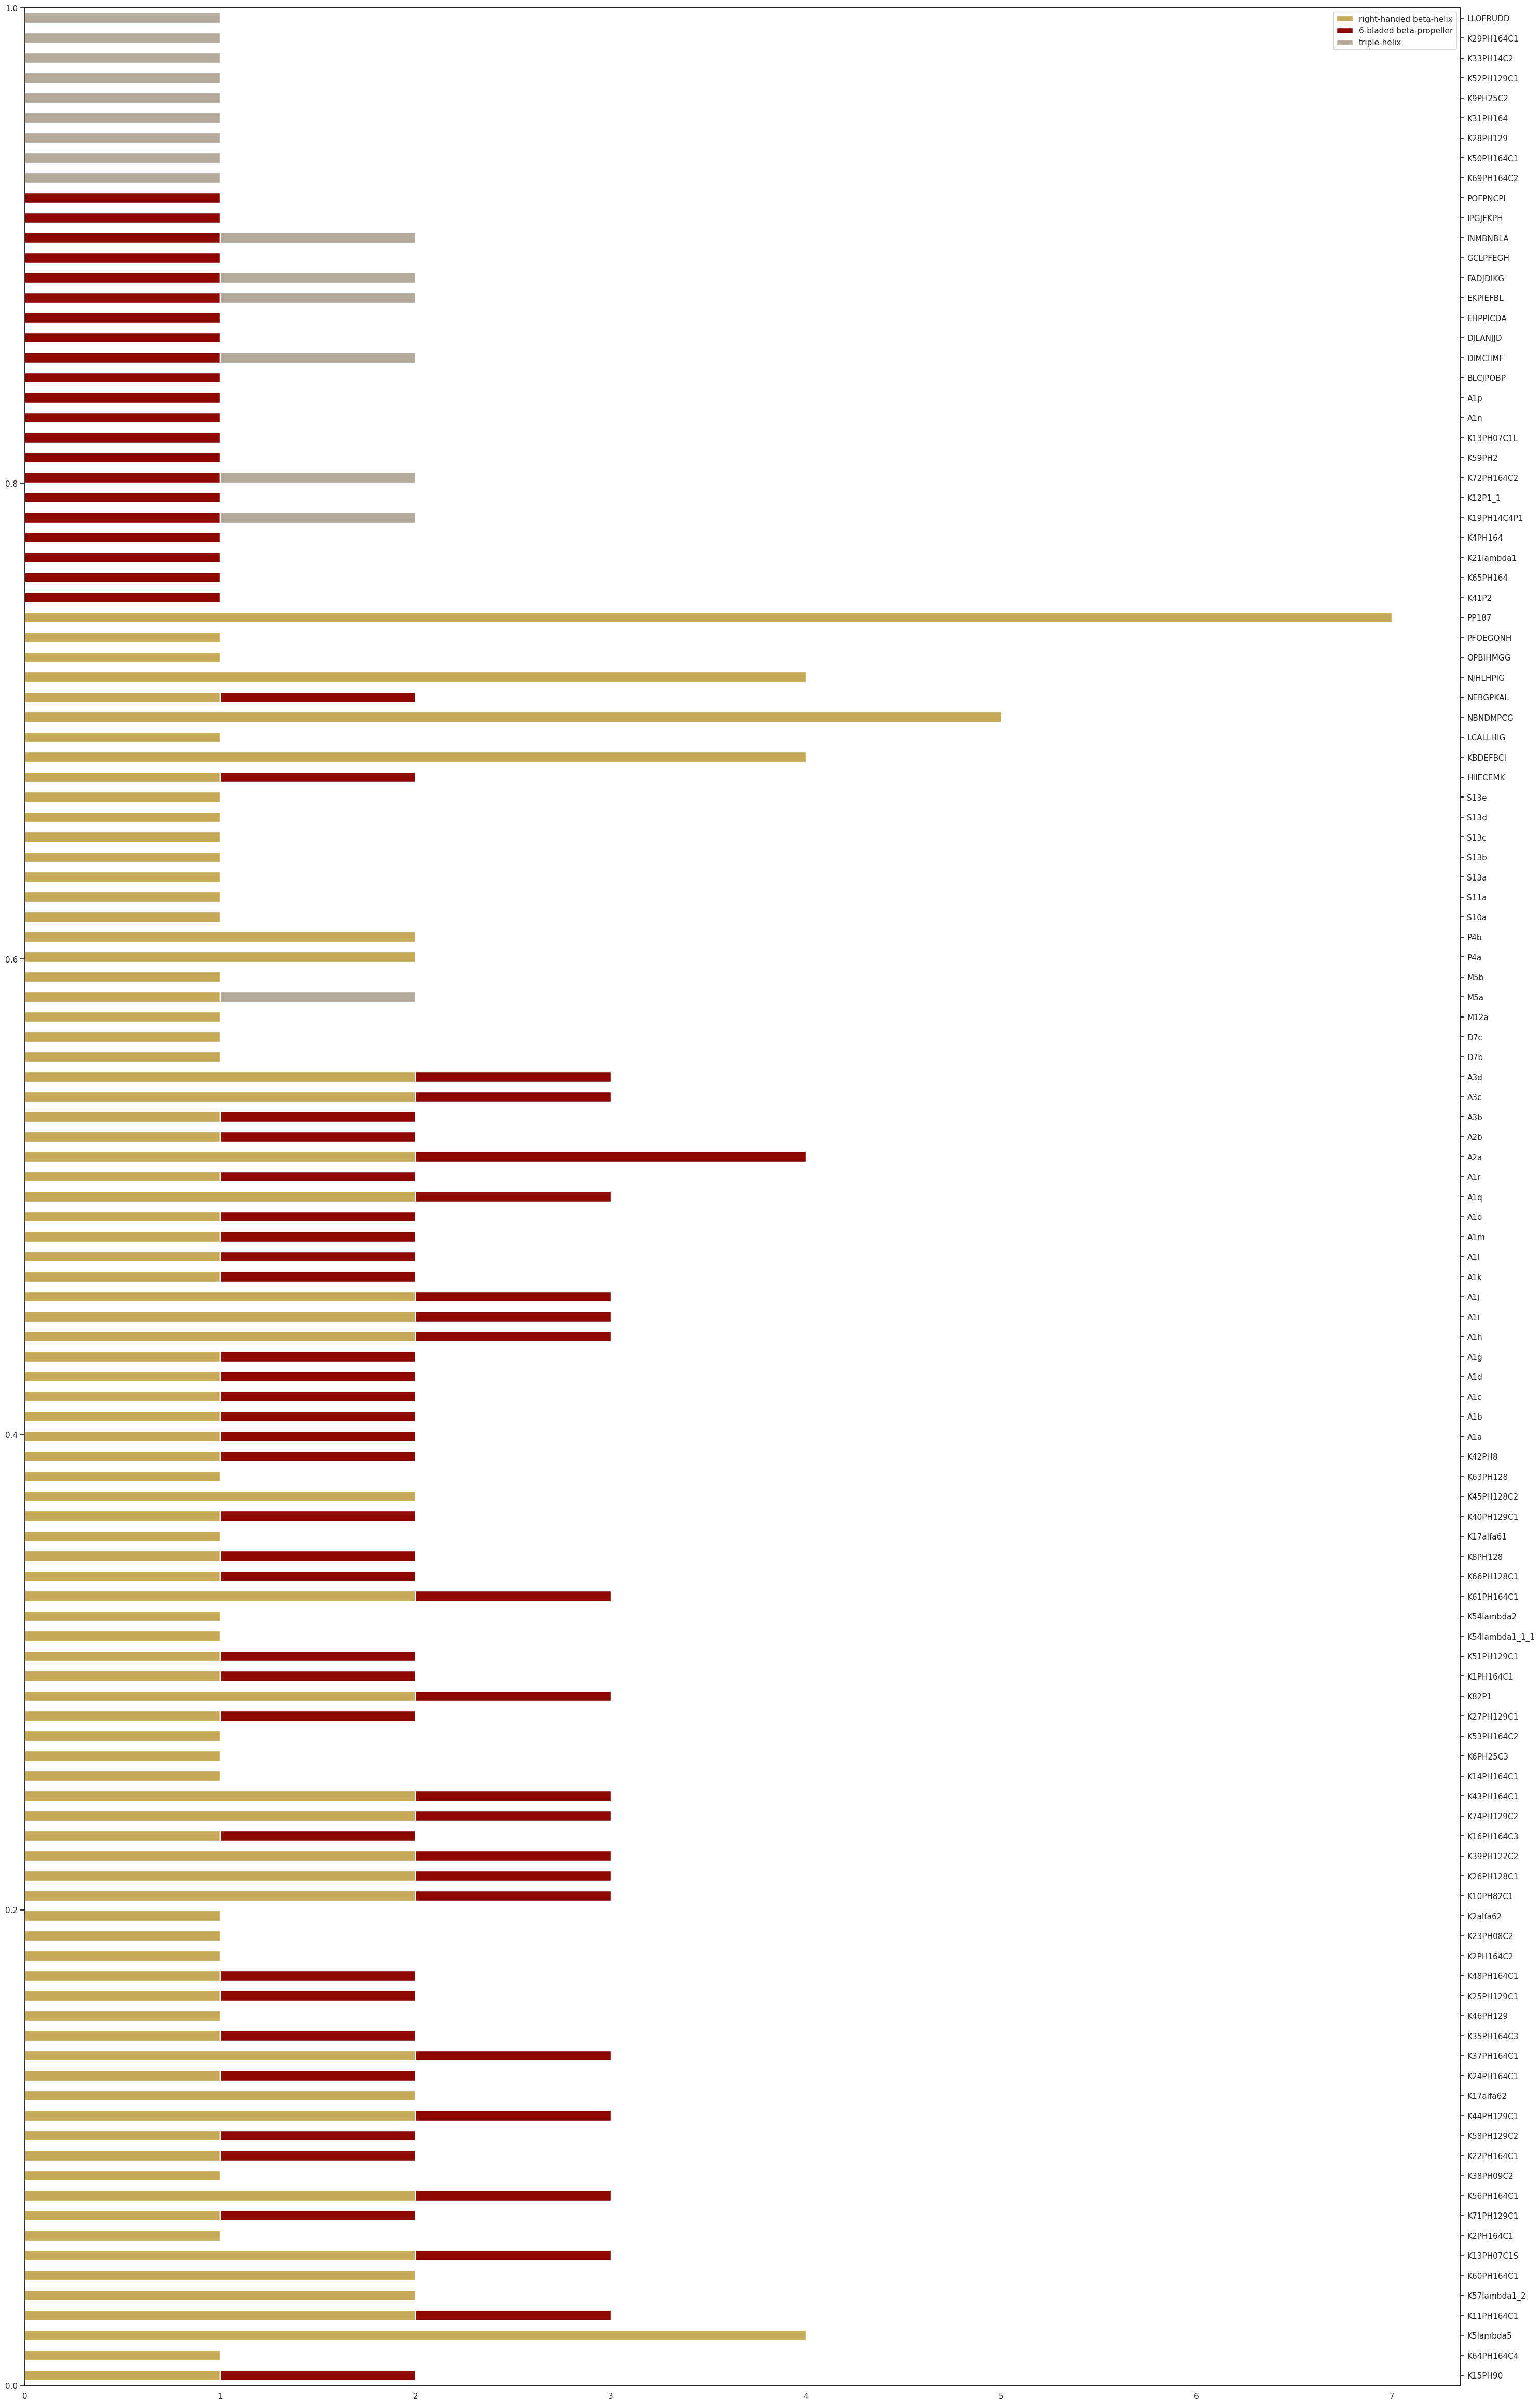

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

# Create the matrix plot (heatmap)
custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", 
    0.5 : "#C9980B",
    0.75 : "#0A5C36", 
    1: '#C80018',    
}
custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f, ax = plt.subplots(figsize=(16, 23))
sns.set(style="white", palette="binary")
sns_plot = sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar=False, 
                      linewidths=1.9, 
                      ax=ax, 
                      yticklabels=True,
                      xticklabels=True,
                      cmap=custom_cmap)
ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False, left=False, right=True, labelleft=True, labelright=False)  # Hide left ticks and labels
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize=7, rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize=7, rotation=0)  # Rotate y-axis labels
f.savefig(path_out+"/matrix_lytic_phages.top40.png", transparent=True, dpi=600)
plt.show()

# Create the barplot
df = pd.DataFrame.from_dict(all_folds, orient='index')
color_dict = {'right-handed beta-helix': '#c6aa58ff', 
              '6-bladed beta-propeller': '#8d0801ff', 
              'triple-helix': '#b3aa99ff'}
num_elements = len(df.index)
figsize = (num_elements*0.3, num_elements*0.5)  # Adjust the size for proper visualization
ax2 = plt.twinx()  # Create a twin Axes sharing the yaxis
df.plot(kind='barh', stacked=True, color=color_dict.values(), figsize=figsize, ax=ax2)
#plt.ticklabel_format(style='plain', useOffset=False, axis='x')
plt.gca().set_xlabel("Count")
plt.savefig(f'{path_out}/all_stacked_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()


plt.show()

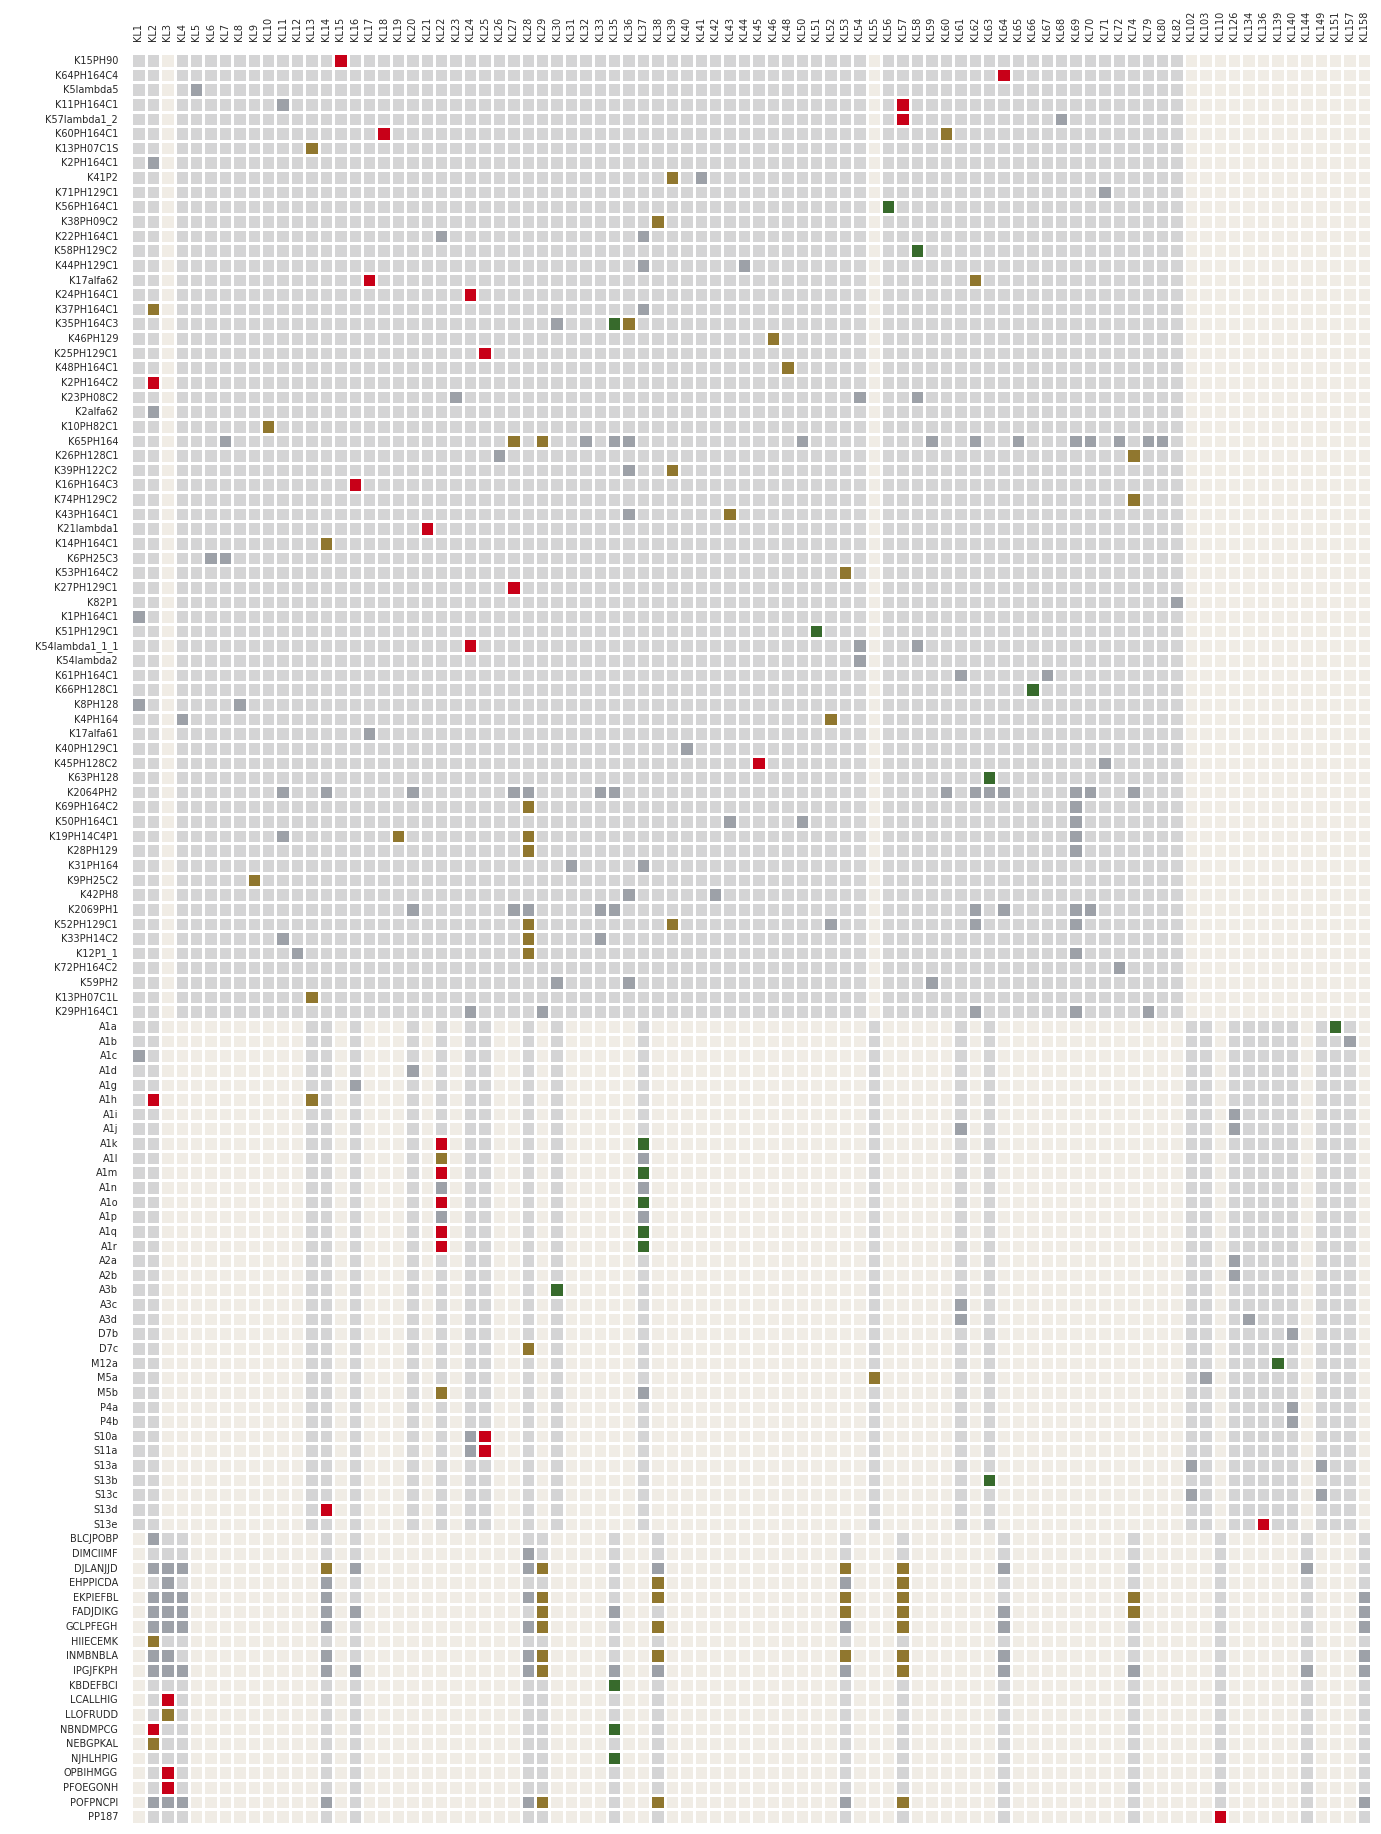

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

# Create the matrix plot (heatmap)
custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", 
    0.5 : "#C9980B",
    0.75 : "#0A5C36", 
    1: '#C80018',    
}
custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f, ax = plt.subplots(figsize=(16, 23))
sns.set(style="white", palette="binary")
sns_plot = sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar=False, 
                      linewidths=1.9, 
                      ax=ax, 
                      yticklabels=True,
                      xticklabels=True,
                      cmap=custom_cmap)
ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize=7, rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize=7)
f.savefig(path_out+"/matrix_lytic_phages.top40.svg", transparent=True, dpi=300)



In [84]:
(250/300) * (550/600) + (40/600)

0.8305555555555555

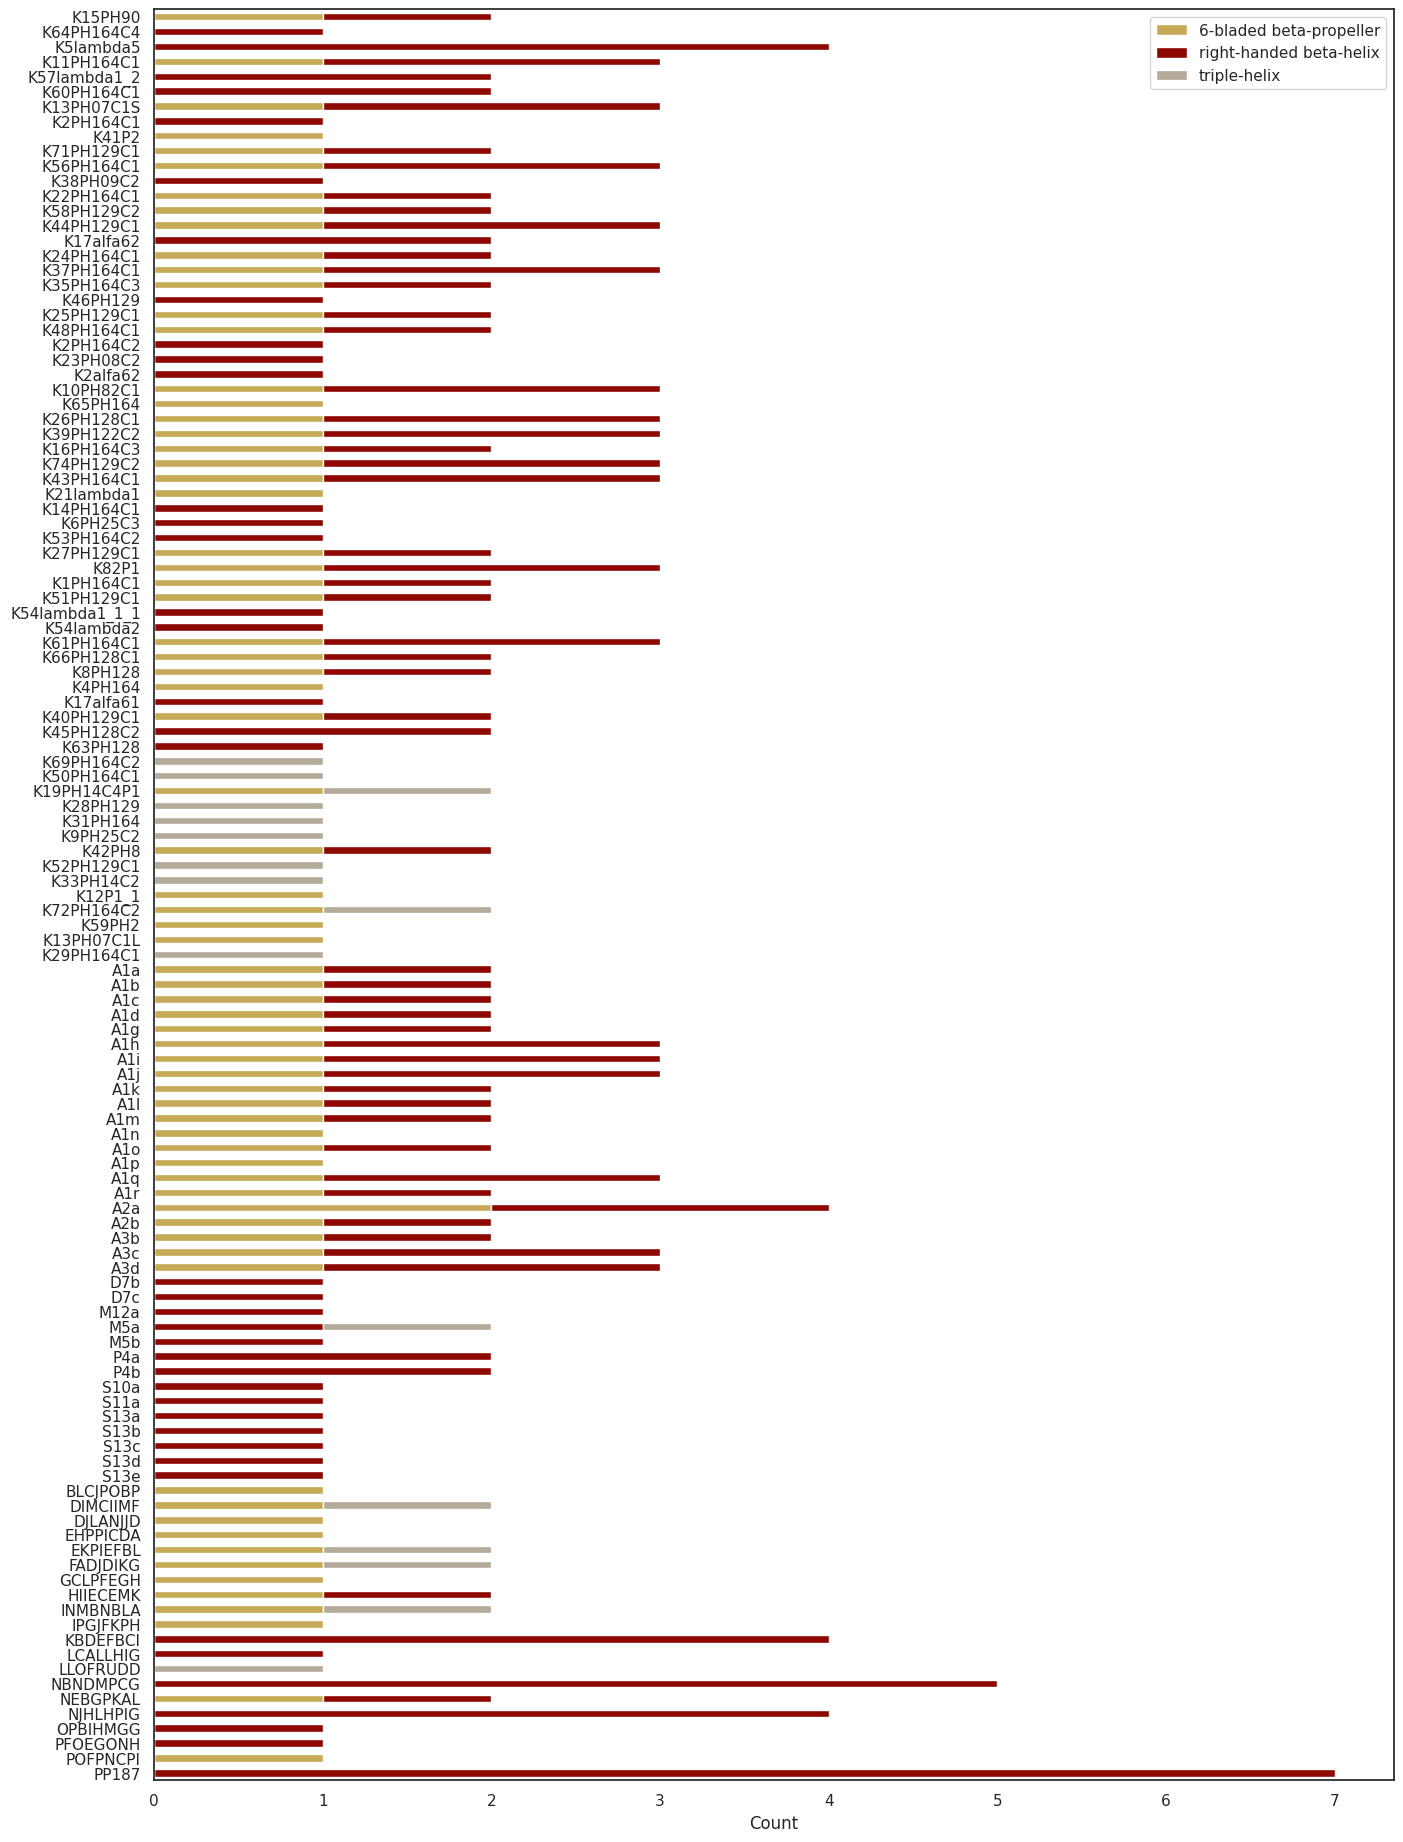

In [12]:
df = pd.DataFrame.from_dict(dico_folds, orient='index')
df = df.reindex(transposed_df.index)

color_dict = {'right-handed beta-helix': '#c6aa58ff', 
              'n-bladed beta-propeller': '#8d0801ff', 
              'triple-helix': '#b3aa99ff'}

figsize = (16, 23)  # Adjust the size for proper visualization
df.plot(kind='barh', stacked=True, color=color_dict.values(), figsize=figsize)
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.savefig(f'{path_out}/all_stacked_bar_plot.2304.svg', dpi=300, bbox_inches='tight')
plt.show()



> backup almost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

path_out = "/media/concha-eloko/Linux/papers/PPT/figures_draft"

# Create the matrix plot (heatmap)
custom_cmap_dict = {
    0: '#F0ECE5',
    0.1: '#B6BBC4',
    0.25 : "#555555", 
    0.5 : "#C9980B",
    0.75 : "#0A5C36", 
    1: '#C80018',    
}
custom_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', list(custom_cmap_dict.values()))
f, ax = plt.subplots(figsize=(16, 23))
sns.set(style="white", palette="binary")
sns_plot = sns.heatmap(transposed_df, linecolor='white', 
                      annot=None, 
                      cbar_ax=None, 
                      cbar=False, 
                      linewidths=1.9, 
                      ax=ax, 
                      yticklabels=True,
                      xticklabels=True,
                      cmap=custom_cmap)
ax.xaxis.tick_top()
sns_plot.set_ylabel(' ', fontsize=14)
ax.tick_params(top=False)
sns_plot.set_xticklabels(sns_plot.get_xmajorticklabels(), fontsize=7, rotation=90)
sns_plot.set_yticklabels(sns_plot.get_ymajorticklabels(), fontsize=7)
f.savefig(path_out+"/matrix_lytic_phages.top40.png", transparent=True, dpi=600)

# Create the barplot
df = pd.DataFrame.from_dict(all_folds, orient='index')
color_dict = {'right-handed beta-helix': '#c6aa58ff', 
              '6-bladed beta-propeller': '#8d0801ff', 
              'triple-helix': '#b3aa99ff'}

#num_elements = len(df.index)
figsize = (23, 10)  # Adjust the size for proper visualization
ax2 = plt.twinx()  # Create a twin Axes sharing the yaxis
df.plot(kind='barh', stacked=True, color=color_dict.values(), figsize=figsize, ax=ax2)
#plt.ticklabel_format(style='plain', useOffset=False, axis='x')
plt.gca().invert_yaxis()
plt.gca().set_xlabel("Count")
plt.savefig(f'{path_out}/all_stacked_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

